In [1]:
import numpy as np
from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation
from pulser.devices import MockDevice
from pulser.waveforms import RampWaveform, ConstantWaveform

import matplotlib.pyplot as plt

import qutip

In [2]:
# Define a dictionary where each key is the name of the qubit,
# and each value is the qubit's position (in um)

qubit_positions = {
    'q0': (0, 0),
    'q1': (3, 5.2),
    'q2': (6, 0),
    'q3': (9, -5.2)
}

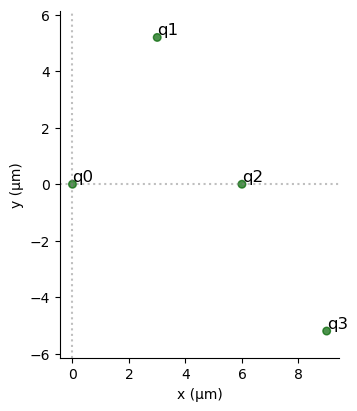

In [3]:
# Arrangements of qubits on the machine are called a register
# Define a register in Pulser by passing the qubit dictionary

reg = Register(qubit_positions)
reg.draw()

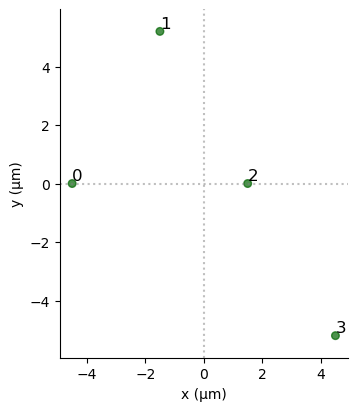

In [4]:
# other ways to create register

pos = [(0, 0), (3, 5.2), (6, 0), (9, -5.2)]
reg = Register.from_coordinates(pos)
reg.draw()

In [5]:
# Define the maximum Rabi frequency by imposing a blockade radius
# (units are um for the blockade radius and rad/us for the rabi frequency)

blockade_radius = 8.7
Omega_max = MockDevice.rabi_from_blockade(blockade_radius)
print(Omega_max)

12.499610303500795


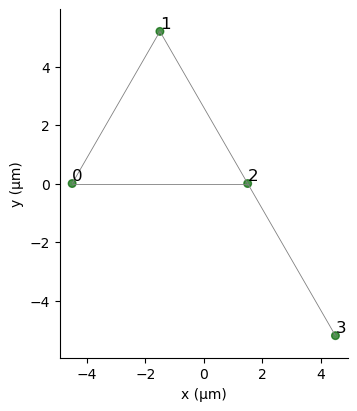

In [6]:
# Visualize the edges induced by the chosen blockade radius

reg.draw(blockade_radius=blockade_radius)

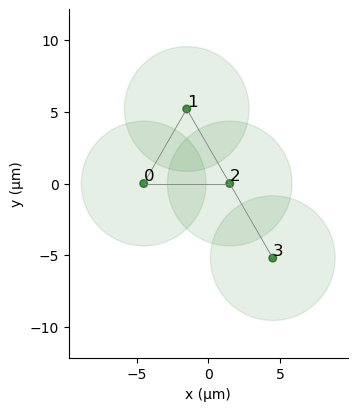

In [7]:
# If you wish, you can also visualize the radius itself

reg.draw(blockade_radius=blockade_radius, draw_half_radius=True)

In [8]:
# A Sequence is the object that contains all the info about the quantum evolution
from pulser import Sequence
from pulser.devices import MockDevice

seq = Sequence(reg, MockDevice)

In [9]:
# Channels are basically the lasers that we want to use, they are attached to a sequence
# They need to be given a name (in this case 'ch') and a type (in this case 'rydberg_global')
# So we are saying that the Sequence `seq` has one global laser called `ch`

seq.declare_channel('ch', 'rydberg_global')

In [10]:
# You can list all the declared channels for a sequence

seq.declared_channels

{'ch': Rydberg.Global(Max Absolute Detuning: None, Max Amplitude: None, Clock period: 1 ns, Minimum pulse duration: 1 ns, Basis: 'ground-rydberg')}

In [12]:
# a laser pulse is a combination of three things:
# duration
# amplitude/intensity/rabi frequency (all synonyms)
# detuning

In [13]:
# Now we want to fill the channel with pulses 
# First we need to define the waveforms for the pulses

from pulser.waveforms import RampWaveform, ConstantWaveform

# First ramp
omega_wf_1 = RampWaveform(300, 0, Omega_max) #arguments are duration (ns), initial Omega (rad/us), final Omega (rad/us)
delta_wf_1 = ConstantWaveform(300, -40) #arguments are duration (ns), detuning (rad/us)


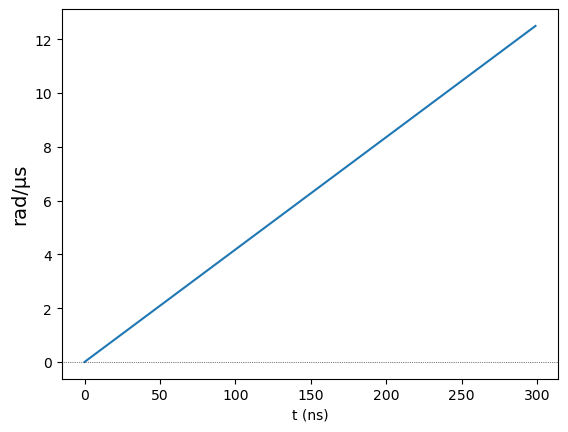

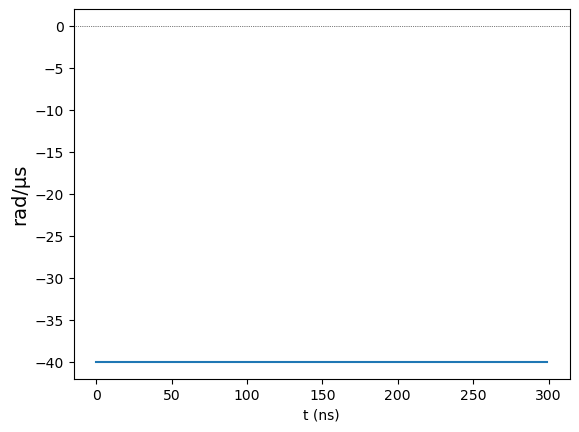

In [15]:
# you can visualize the waveforms
omega_wf_1.draw()
delta_wf_1.draw()

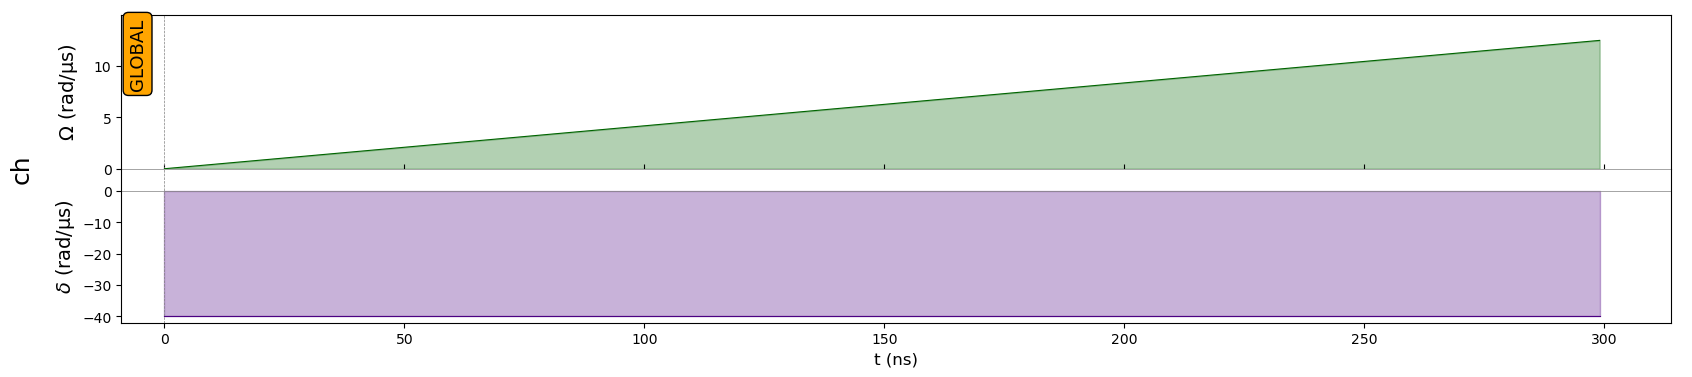

In [16]:
# And now we can create the pulse and add it to the channel
from pulser import Pulse

first_pulse = Pulse(omega_wf_1, delta_wf_1, 0)
seq.add(first_pulse, 'ch')
seq.draw()

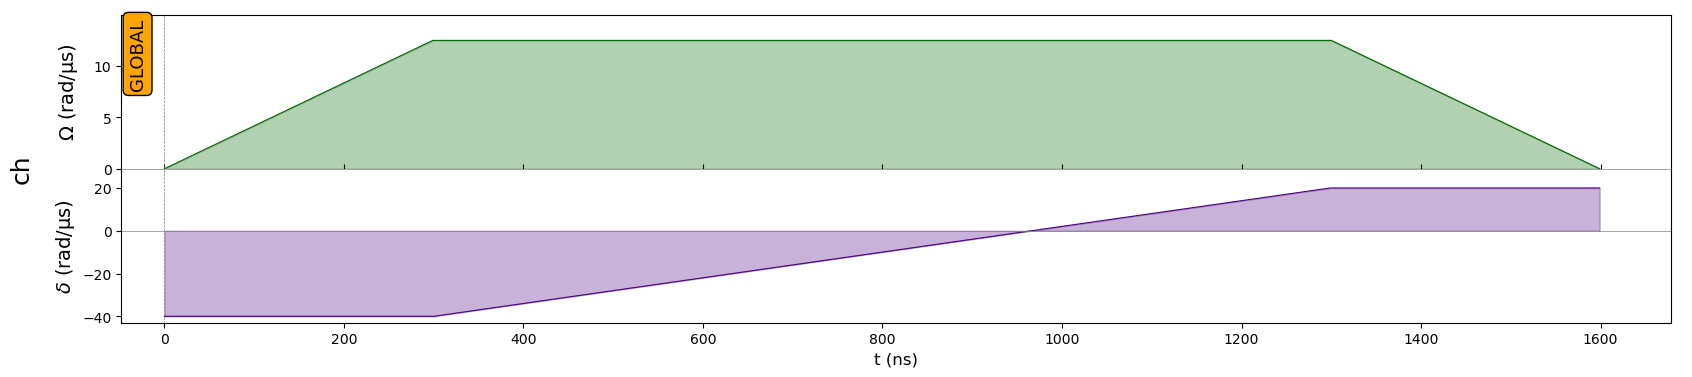

In [17]:
# Do the same for the other two pulses

# Middle part
omega_wf_2 = ConstantWaveform(1000, Omega_max)
delta_wf_2 = RampWaveform(1000, -40, 20)
middle_pulse = Pulse(omega_wf_2, delta_wf_2, 0)
seq.add(middle_pulse, 'ch')

# Final ramp
omega_wf_3 = RampWaveform(300, Omega_max, 0)
delta_wf_3 = ConstantWaveform(300, 20)
final_pulse = Pulse(omega_wf_3, delta_wf_3, 0)
seq.add(final_pulse, 'ch')

seq.draw()

In [18]:
# The sequence is ready now for simulation

sim = Simulation(seq)
results = sim.run()

/Users/maurodarcangelo/miniconda3/envs/main/lib/python3.8/site-packages/pulser_simulation/simulation.py:1196: DeprecationWarning: The `Simulation` class is deprecated, use `QutipEmulator.from_sequence` instead.
  warnings.warn(


In [20]:
# The final wavefuction of the system can be sampled

samples = results.sample_final_state(10000)

<BarContainer object of 7 artists>

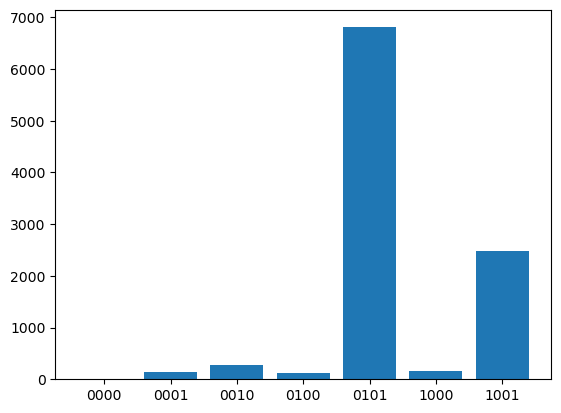

In [21]:
# And the sampling can be visualized

plt.bar(samples.keys(), samples.values())

In [22]:
# If you want, you can work with the computed final state (it's a qutip object)

final_state = results.get_final_state()
print(final_state)

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[-2.05904722e-06-5.29172322e-06j]
 [ 6.44889034e-07+2.64956951e-06j]
 [ 3.00549213e-03+5.53132444e-04j]
 [ 4.95969881e-04+9.50608480e-04j]
 [ 6.74718443e-05+3.32932285e-04j]
 [ 1.05183168e-04+5.29667872e-04j]
 [ 3.39320430e-01-3.71013850e-01j]
 [ 1.27881982e-01+2.98369859e-02j]
 [-2.40205916e-04+3.17117542e-04j]
 [ 1.80755617e-04+3.13320481e-04j]
 [ 8.22521208e-01+0.00000000e+00j]
 [ 9.60796954e-02+5.11723643e-02j]
 [-2.41506364e-04+2.68901966e-06j]
 [ 1.56717057e-01-2.48262980e-02j]
 [ 6.77305431e-02+1.06398905e-01j]
 [-1.50238418e-03+2.18410143e-02j]]


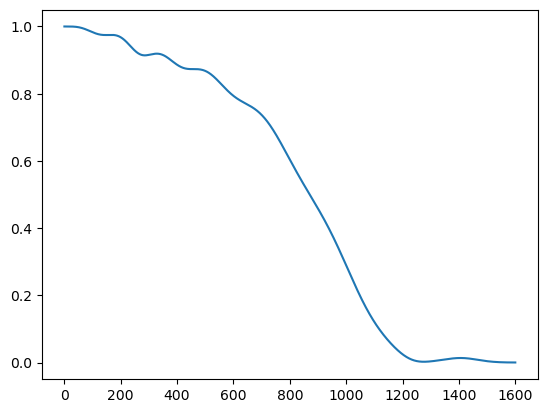

In [23]:
# The `results` object contains info on the whole dynamics
# For example, you can compute the expectation value of a variable over time

# Projector of the initial state |0000>
observable = qutip.tensor([
    qutip.basis(2, 1),
    qutip.basis(2, 1),
    qutip.basis(2, 1),
    qutip.basis(2, 1),
]).proj() #careful: |0> is the vector (0,1), and |1> is the vector (1,0), not the other way around!

# Calculate expectation value
obs_exp = results.expect([observable])

# Plot
plt.plot(obs_exp[0])

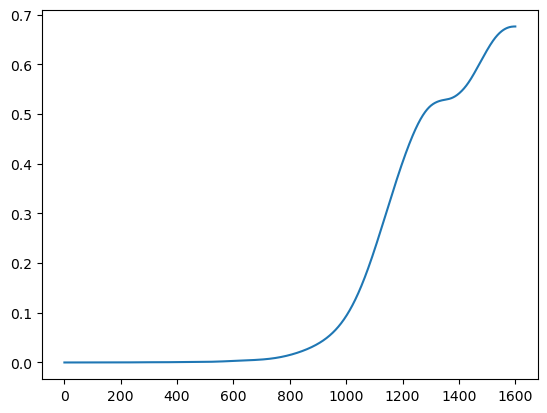

In [24]:
# Let's look at the expectation value of the projector of the MIS state |0101>

# Projector of the initial state |0101>
observable = qutip.tensor([
    qutip.basis(2, 1),
    qutip.basis(2, 0),
    qutip.basis(2, 1),
    qutip.basis(2, 0),
]).proj()

# Calculate expectation value
obs_exp = results.expect([observable])

# Plot
plt.plot(obs_exp[0])